# Librerías

In [153]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Carga y preprocesamiento de datos de entrenamiento

In [154]:
def load_and_preprocess_data():
    train_data = pd.read_csv('train_hora.csv')
    temp_max = pd.read_csv('DMC_330020_Quinta_Normal_Santiago_maxima.csv')
    temp_media = pd.read_csv('DMC_330020_Quinta_Normal_Santiago_media.csv')
    temp_min = pd.read_csv('DMC_330020_Quinta_Normal_Santiago_minima.csv')

    for df in [train_data, temp_max, temp_media, temp_min]:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

    combined_data = train_data.join([temp_max['t_maxima'], temp_media['t_media'], temp_min['t_minima']], how='inner')
    combined_data.columns = ['consumption', 't_maxima', 't_media', 't_minima']

    scalers = {}
    for col in combined_data.columns:
        scaler = MinMaxScaler(feature_range=(0, 1))
        combined_data[f"{col}_scaled"] = scaler.fit_transform(combined_data[col].values.reshape(-1, 1))
        scalers[col] = scaler

    data_for_model = combined_data[['consumption_scaled', 't_maxima_scaled', 't_media_scaled', 't_minima_scaled']]

    return data_for_model, scalers

data_for_model, scalers = load_and_preprocess_data()

# Función Secuencia

In [155]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 0]) 
    return np.array(sequences), np.array(targets)

In [156]:
# Parámetros
sequence_length = 24
X_train, y_train = create_sequences(data_for_model.values, sequence_length)
print("Shape de X_train:", X_train.shape)

Shape de X_train: (1437, 24, 4)


# API Funcional

In [157]:
# API Funcional
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2])) 
x = LSTM(64, return_sequences=False)(input_layer)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 24, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento del modelo

In [158]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1)
model.save('modelo1_temp.keras')


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2664 - mae: 0.4165 - val_loss: 0.0050 - val_mae: 0.0568
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - mae: 0.0500 - val_loss: 0.0026 - val_mae: 0.0391
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - mae: 0.0428 - val_loss: 0.0026 - val_mae: 0.0389
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mae: 0.0385 - val_loss: 0.0025 - val_mae: 0.0372
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - mae: 0.0415 - val_loss: 0.0025 - val_mae: 0.0372
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - mae: 0.0396 - val_loss: 0.0024 - val_mae: 0.0364
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - mae: 0.0394 - val_loss: 0.0024 - val_mae: 0.0361
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mae: 0.0374 - val_loss: 0.0024 - val_mae: 0.0361
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.00

# Carga y procesamiento de datos de prueba

In [159]:
test_data = pd.read_csv('test_hora.csv')
temp_max_test = pd.read_csv('DMC_330020_Quinta_Normal_Santiago_maxima.csv') 
temp_media_test = pd.read_csv('DMC_330020_Quinta_Normal_Santiago_media.csv')
temp_min_test = pd.read_csv('DMC_330020_Quinta_Normal_Santiago_minima.csv')

test_data['date'] = pd.to_datetime(test_data['date'])
temp_max_test['date'] = pd.to_datetime(temp_max_test['date'])
temp_media_test['date'] = pd.to_datetime(temp_media_test['date'])
temp_min_test['date'] = pd.to_datetime(temp_min_test['date'])

combined_test_data = test_data.join([temp_max_test['t_maxima'], temp_media_test['t_media'], temp_min_test['t_minima']], how='inner')

combined_test_data['consumption_scaled'] = scaler_consumption.transform(combined_test_data['consumption'].values.reshape(-1, 1))
combined_test_data['temp_max_scaled'] = scaler_temp_max.transform(combined_test_data['t_maxima'].values.reshape(-1, 1))
combined_test_data['temp_media_scaled'] = scaler_temp_media.transform(combined_test_data['t_media'].values.reshape(-1, 1))
combined_test_data['temp_min_scaled'] = scaler_temp_min.transform(combined_test_data['t_minima'].values.reshape(-1, 1))

X_test, y_test = create_sequences(combined_test_data[['consumption_scaled', 'temp_max_scaled', 'temp_media_scaled', 'temp_min_scaled']].values, sequence_length)

predictions = model.predict(X_test)
predictions_rescaled = scaler_consumption.inverse_transform(predictions)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


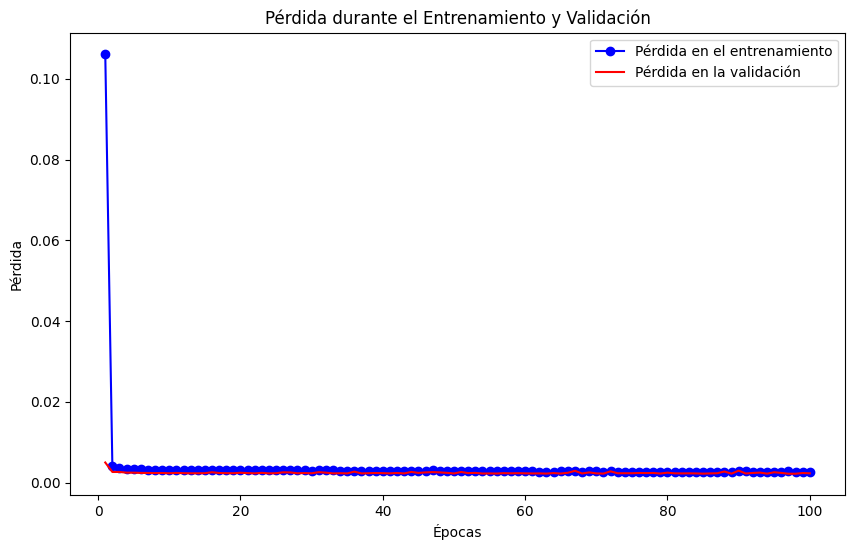

In [167]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, 'bo-', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss_values, 'r-', label='Pérdida en la validación')
plt.title('Pérdida durante el Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Evaluación del modelo

In [160]:
y_true = combined_test_data['consumption'].values[sequence_length:]
mse = mean_squared_error(y_true, predictions_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, predictions_rescaled)

print(f'RMSE: {rmse}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')

RMSE: 7.695605338818935
MSE: 59.22234153085849
MAE: 6.297368358741413


# Predicción vs valores reales

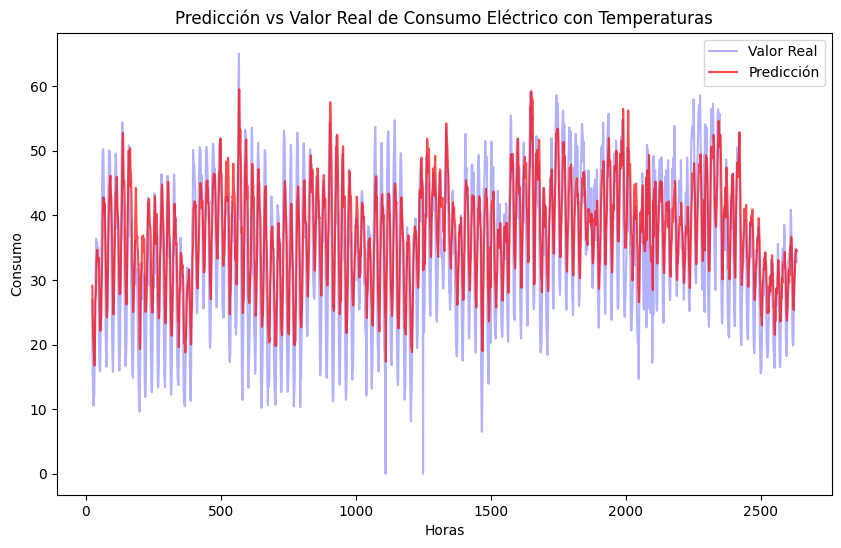

In [161]:
plt.figure(figsize=(10, 6))
plt.plot(combined_test_data.index[sequence_length:], combined_test_data['consumption'][sequence_length:], label='Valor Real', color='blue', alpha=0.3)
plt.plot(combined_test_data.index[sequence_length:], predictions_rescaled, label='Predicción', color='red', alpha=0.7)
plt.title('Predicción vs Valor Real de Consumo Eléctrico con Temperaturas')
plt.xlabel('Horas')
plt.ylabel('Consumo')
plt.legend()
plt.show()

In [162]:
day_index = 5
start = day_index * 24
end = (day_index + 1) * 24

# Visualización: Métricas durante el entrenamiento

Predicción para el día: 144


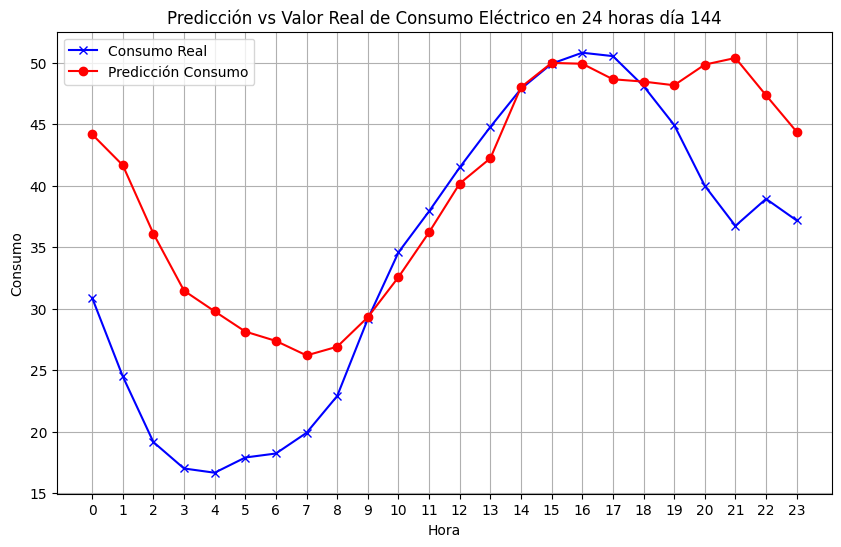

In [163]:
mse_train = history.history['loss']
mse_val = history.history['val_loss']
mae_train = history.history['mae']
mae_val = history.history['val_mae']

rmse_train = [np.sqrt(x) for x in mse_train]
rmse_val = [np.sqrt(x) for x in mse_val]

if end > len(predictions_rescaled) or end > len(combined_test_data):
    print(f"El day_index {day_index} no tiene suficientes datos para 24 horas.")
    
prediction_date = combined_test_data.index[sequence_length + start]
print(f"Predicción para el día: {prediction_date}")
# Extraer los valores de consumo real y predicho para las 24 horas seleccionadas
predicted_24h = predictions_rescaled[start:end].flatten()
real_24h = combined_test_data['consumption'].values[sequence_length + start:sequence_length + end]
hours = list(range(24))
plt.figure(figsize=(10, 6))
plt.plot(hours, real_24h, label='Consumo Real', color='blue', marker='x')
plt.plot(hours, predicted_24h, label='Predicción Consumo', color='red', marker='o')

plt.title(f'Predicción vs Valor Real de Consumo Eléctrico en 24 horas día {prediction_date}')
plt.xlabel('Hora')
plt.ylabel('Consumo')
plt.xticks(hours) 
plt.legend()
plt.grid(True)

plt.show()

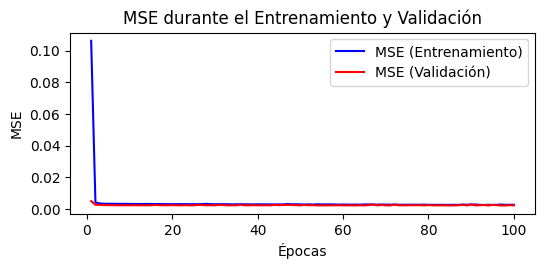

In [168]:
epochs = range(1, len(mse_train) + 1)

plt.figure(figsize=(6, 8))

plt.subplot(3, 1, 1)
plt.plot(epochs, mse_train, 'b-', label='MSE (Entrenamiento)')
plt.plot(epochs, mse_val, 'r-', label='MSE (Validación)')
plt.title('MSE durante el Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

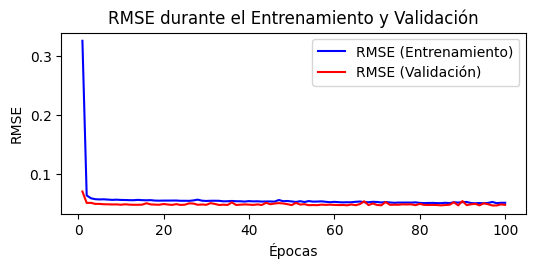

In [169]:
plt.figure(figsize=(6, 8))
plt.subplot(3, 1, 2)
plt.plot(epochs, rmse_train, 'b-', label='RMSE (Entrenamiento)')
plt.plot(epochs, rmse_val, 'r-', label='RMSE (Validación)')
plt.title('RMSE durante el Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('RMSE')
plt.legend()

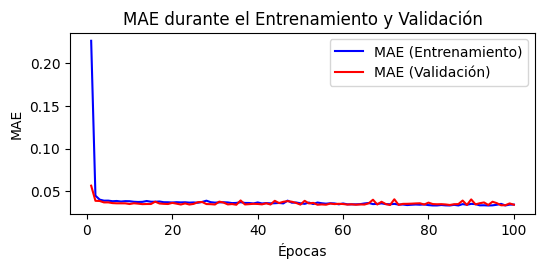

In [170]:
plt.figure(figsize=(6, 8))
plt.subplot(3, 1, 3)
plt.plot(epochs, mae_train, 'b-', label='MAE (Entrenamiento)')
plt.plot(epochs, mae_val, 'r-', label='MAE (Validación)')
plt.title('MAE durante el Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()